In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.filterwarnings('ignore')
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Our so-called "masterlist" - a merge of CTCF and RAD21 peaks - as a collection of
# biologically relevant sites to look at ...
feat_names = OrderedDict()
feat_names["rad_ctcf_union"] = "allTSS_wstrand.bed"

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [5]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end","strand"],
        usecols=(0,1,2,3),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)


### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


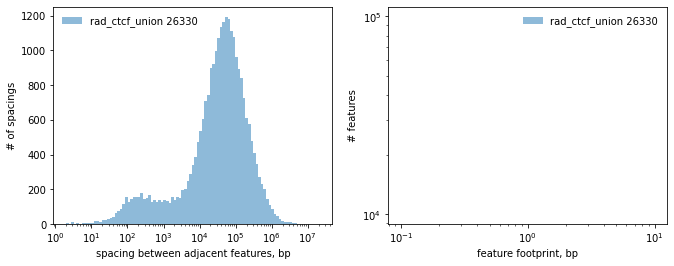

In [6]:
plot_spacing_footprint_distros(dfs)

### let's have the original CTCF and RAD21 peak calls here to count them along our stackups as well (kind of sliding window, but not really sliding ...) ...

Also we agreed to add matching motif analyses here - G4-seq(not quite a motif, but just another way to get at G4-s) and FIMO-scanned CTCF `MA0139.1` motifs as well ...

##### Let's load called ChipSeq peaks for our "grey-plots" ("quantifications") here ...

##### We also need G4 data for the grey plots ("quantifications") here as well ...

In [7]:
# G4-seq : G4 stalled at polymerase, more comprehensive list (hg19):
# G4-seq data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63874
# ls ../GSE*bed.gz
# require tr -s '\t' - to remove duplicated tabs
# we've got + and - strand G4s separately ...
G4_minus_polstall = bioframe.read_table(
    "GSE63874_Na_K_PDS_minus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = bioframe.read_table(
    "GSE63874_Na_K_PDS_plus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = G4_plus_polstall.sort_values(["chrom","start"])
G4_plus_polstall = G4_plus_polstall[ G4_plus_polstall["chrom"].isin(autosomal_chroms) ]
G4_plus_polstall = G4_plus_polstall.reset_index(drop=True)
print(f"G4+ alone {len(G4_plus_polstall)} ...")

G4_minus_polstall = G4_minus_polstall.sort_values(["chrom","start"])
G4_minus_polstall = G4_minus_polstall[ G4_minus_polstall["chrom"].isin(autosomal_chroms) ]
G4_minus_polstall = G4_minus_polstall.reset_index(drop=True)
print(f"G4- alone {len(G4_minus_polstall)} ...")

G4_polstall = bf.merge(
    pd.concat([G4_plus_polstall,G4_minus_polstall]).reset_index(drop=True), # !!! Achtung !!! resetting_index is Yber important here!
#     min_dist=merge_radius
)
G4_polstall = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
print(f"G4-+ together {len(G4_polstall)}, would have been {len(G4_plus_polstall)+len(G4_minus_polstall)} ...")
# G4_polstall.head()

G4+ alone 198824 ...
G4- alone 195394 ...
G4-+ together 378344, would have been 394218 ...


In [8]:
# turn G4-seq data into bigBED files to plot them in the form of stackups as well ...

# save DataFrame as Bed:
fname = "G4_minus_polstall"
_df = G4_minus_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
_df[["chrom","start","end"]].to_csv(f"{fname}.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 {fname}.bed hg19.sizes {fname}.bb

fname = "G4_plus_polstall"
_df = G4_plus_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
_df[["chrom","start","end"]].to_csv(f"{fname}.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 {fname}.bed hg19.sizes {fname}.bb

fname = "G4_polstall"
_df = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
_df[["chrom","start","end"]].to_csv(f"{fname}.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 {fname}.bed hg19.sizes {fname}.bb


pass1 - making usageList (22 chroms): 25 millis
pass2 - checking and writing primary data (195394 records, 3 fields): 163 millis
pass1 - making usageList (22 chroms): 27 millis
pass2 - checking and writing primary data (198824 records, 3 fields): 171 millis
pass1 - making usageList (22 chroms): 46 millis
pass2 - checking and writing primary data (378344 records, 3 fields): 307 millis


### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [23]:
#let's describe our samples that we want to have in Figure 1 ...
supfig2A_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","h3k4_k562","polII","h3k4_r1","mrna_ctcf"]
titles = supfig2A_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in supfig2A_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [10]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks(bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features rad_ctcf_union:(26330) ...


stacking up ctcf ...
CPU times: user 3.98 s, sys: 220 ms, total: 4.2 s
Wall time: 4.17 s
stacking up noctcf ...
CPU times: user 3.76 s, sys: 136 ms, total: 3.9 s
Wall time: 3.91 s
stacking up rad21_CTCF ...
CPU times: user 4.25 s, sys: 193 ms, total: 4.45 s
Wall time: 4.43 s
stacking up rad21_noCTCF ...
CPU times: user 3.53 s, sys: 136 ms, total: 3.67 s
Wall time: 3.65 s
stacking up ins_CTCF ...
CPU times: user 3.08 s, sys: 152 ms, total: 3.23 s
Wall time: 3.22 s
stacking up ins_noCTCF ...
CPU times: user 3.23 s, sys: 173 ms, total: 3.4 s
Wall time: 3.4 s
stacking up G4a_r2 ...
CPU times: user 5.6 s, sys: 161 ms, total: 5.76 s
Wall time: 5.77 s
stacking up h3k4_k562 ...
CPU times: user 6.98 s, sys: 236 ms, total: 7.22 s
Wall time: 7.18 s
stacking up polII ...
CPU times: user 3.08 s, sys: 140 ms, total: 3.22 s
Wall time: 3.21 s
stacking up h3k4_r1 ...
CPU times: user 5.16 s, sys: 177 ms, total: 5.34 s
Wall time: 5.31 s
stacking up m

In [26]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "gene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "gene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
supfig2A_samples.append(feat_name)
titles = supfig2A_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

# try to discriminate overlaping genes with the lack of genes  - white/gray  - fill missing nan ....

stacking genes up for rad_ctcf_union ...


In [27]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "g4seq"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "G4_polstall.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa
    
#let's describe our samples that we want to have in Figure 1 ...
supfig2A_samples.append(feat_name)
titles = supfig2A_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (0,1)
cmps[s] = "Blues"
norms[s] = None

# try to discriminate overlaping genes with the lack of genes  - white/gray  - fill missing nan ....

stacking genes up for rad_ctcf_union ...


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [13]:
# this is done INPLACE - be carefull !
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

for feature_key in stackup_dict:
    the_stackup = stackup_dict[feature_key]
    # define the size of the shoulder - flank size
    l, w = the_stackup["ins_CTCF"].shape
    norm_flank = int(w*0.25)

    normalize_insulation_stackups_INPLACE(
        the_stackup,
        insulation_keys,
        subtract = "shoulders",
        subtract_size = norm_flank,
    )

In [24]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.25,0.02)
    cmps[s] = cmapYlGnBu_r

### starting with some sorting, keeping legacy sorting approaches for now

In [15]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in stackup_dict:
    the_stackups = stackup_dict[feature_key]
    length,width = the_stackups['h3k4_r1'].shape
    center_bin = int(width/2)
    # h3k4_r1 is a narrow signal - so sorting on 2 bins around cener should be ok ...
    the_stackups['K4_mean'] = np.nanmean(the_stackups['h3k4_r1'][:,center_bin-3:center_bin+3],axis=1)
    _, _jjj = recursive_data_ordering(
                ks = [('K4_mean', "sort", 1, False)],
                idxs = np.arange( length ),
                data_dict = the_stackups,
                verbose=True,
    )
    reordered_jdxs[feature_key] = _jjj



sorting 26330 elements of K4_mean into 1 groups ...


### let's perform a scientific selection of the number of active TSS - as a "place" where K4_mean signal drops from to None ...

this can be done by averaging K4 over different number of bins around TSS - we concluded that -1,+1 (2 bins-wide) is too narrow, and +/-3 and +/-2 are very similar, "reliable" and smooth - and we chose +/-3 (6-200bp bins wide) for the downstream analysis ...

#### plotting those running averages is integrated into `plot_stackups` function ...

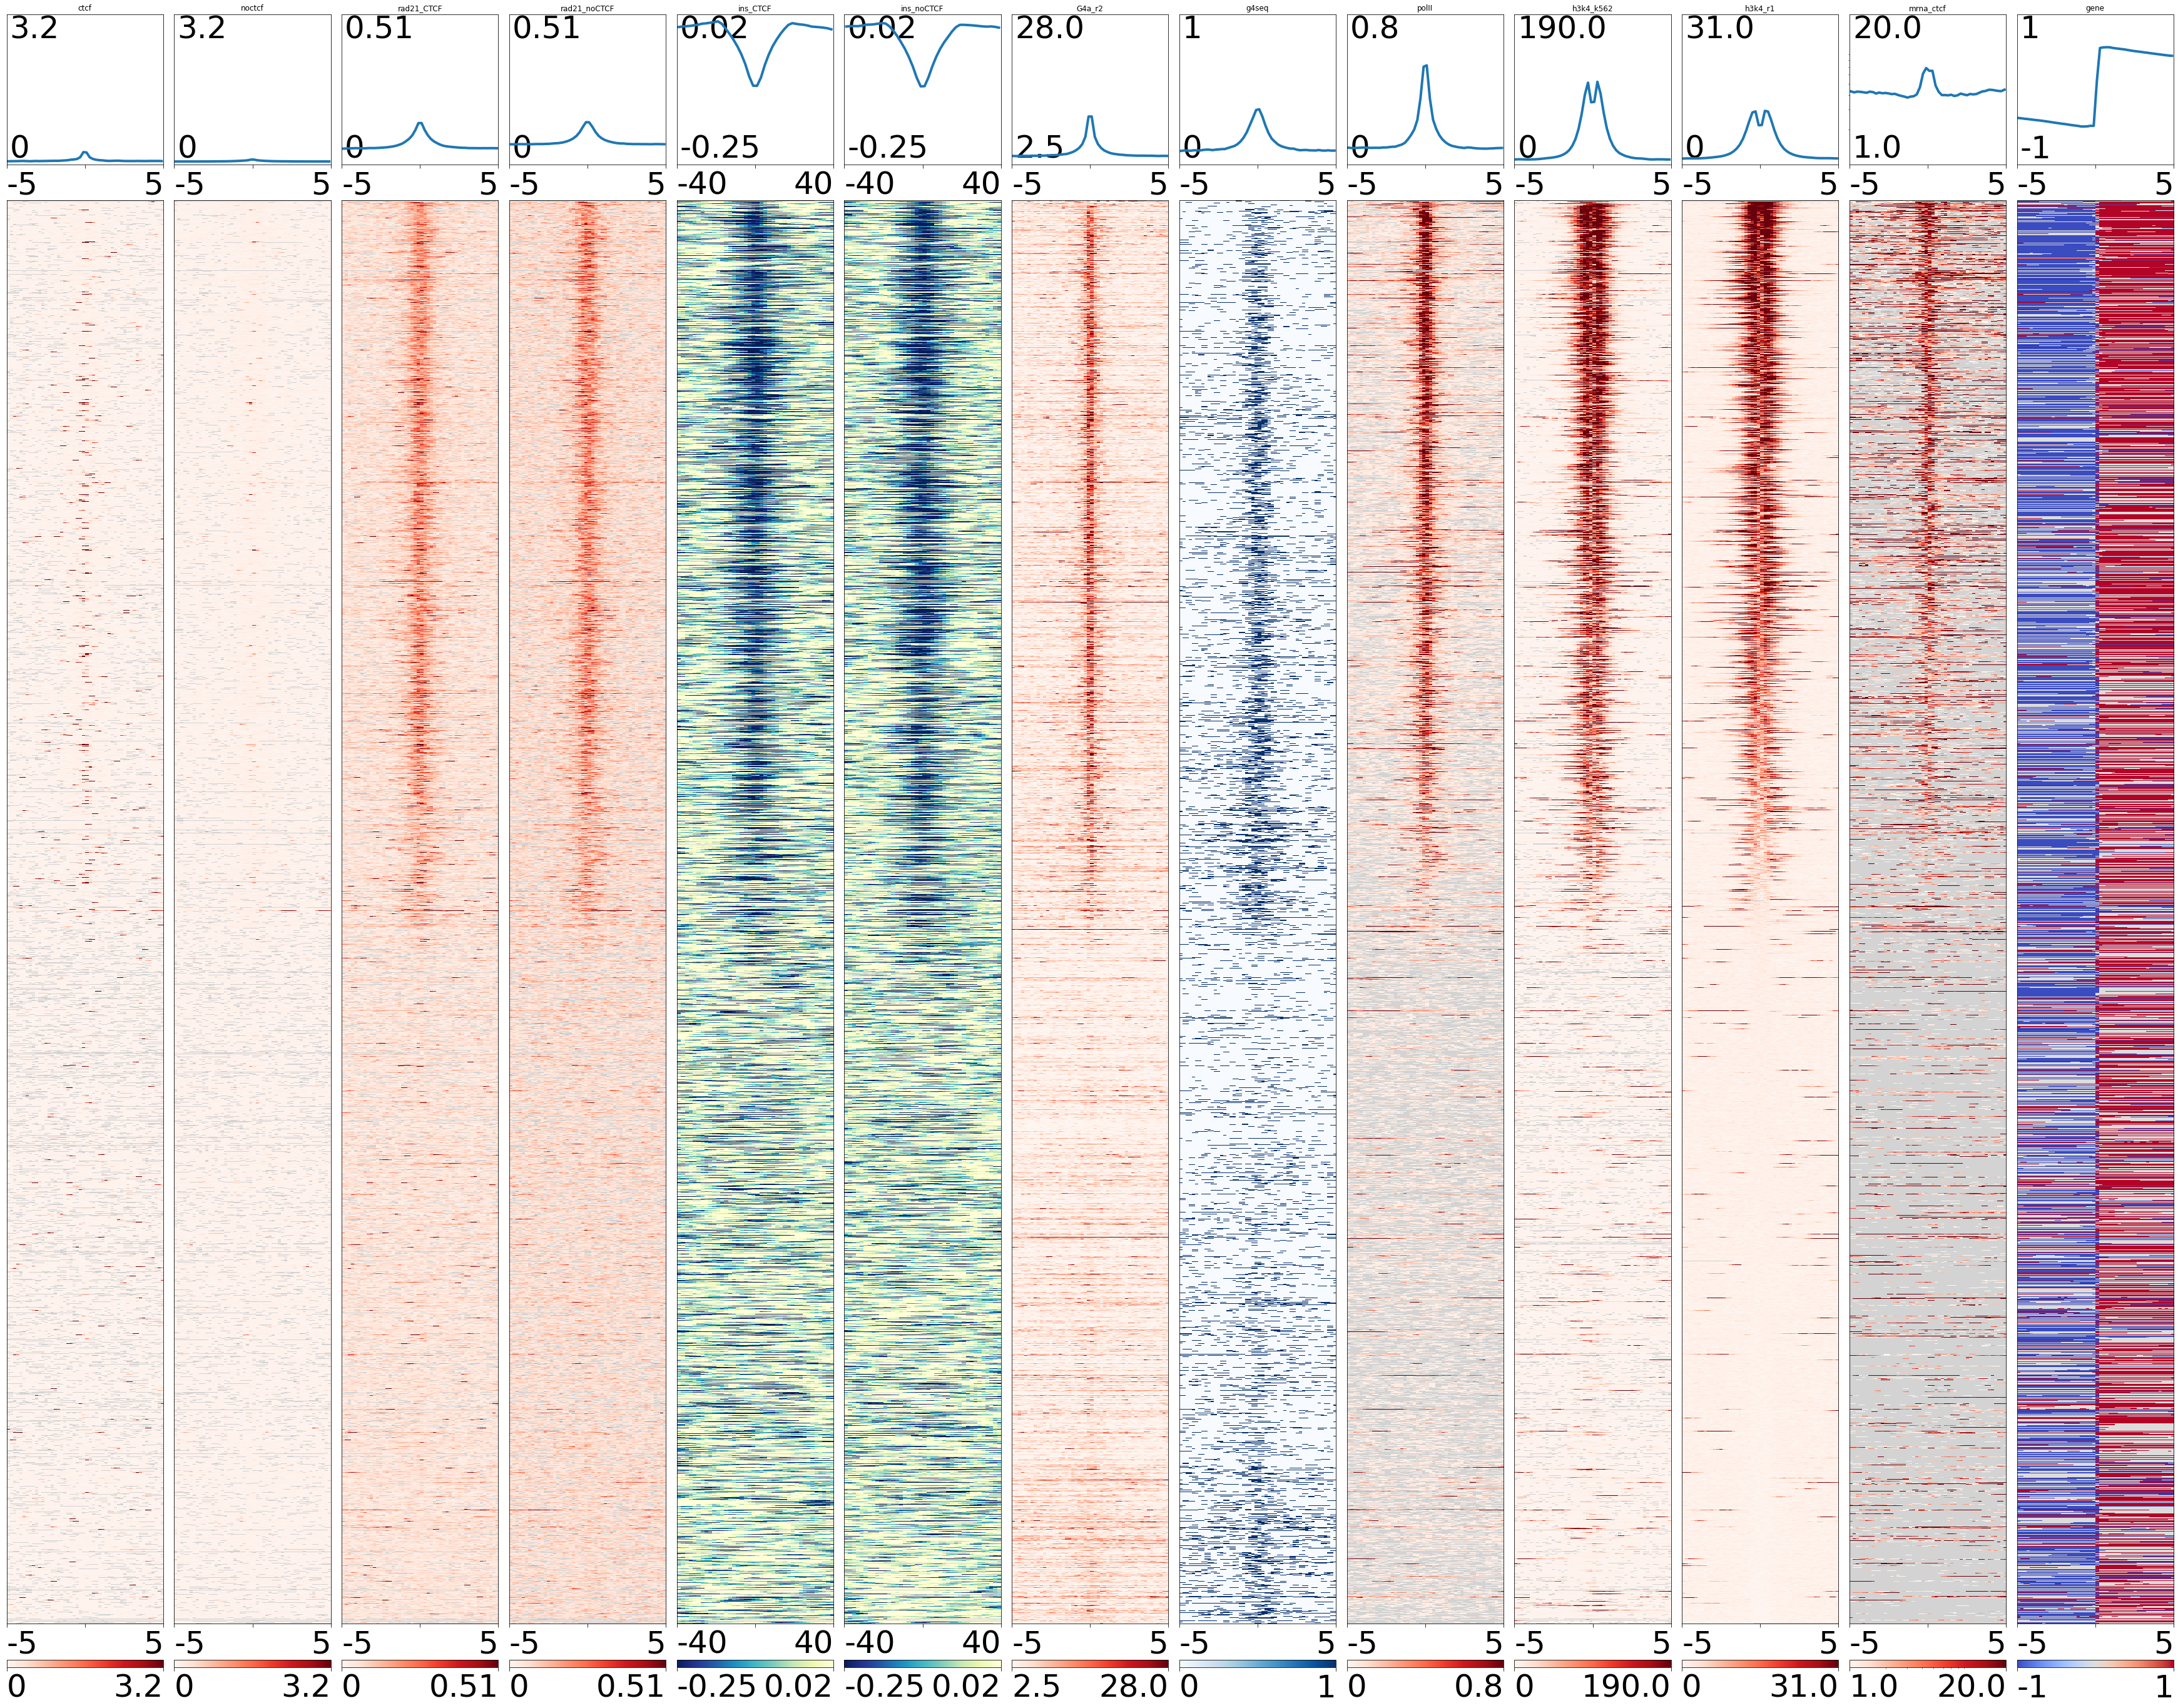

In [28]:
hmss = OrderedDict()

for feature_key in stackup_dict:
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in supfig2A_samples ]

_limss = [ limss[_k] for _k in supfig2A_samples ]
_cmps = [ cmps[_k] for _k in supfig2A_samples ]
_binsizes = [ binsizes[_k] for _k in supfig2A_samples ]
_norms = [ norms[_k] for _k in supfig2A_samples ]

extra_order = None
hmss_order = [0,1,2,3,4,5,6,9,8,10,11,12,7]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

# plt.savefig("Fig1_masterlist_all.pdf")

### let's plot active TSSs only ...

let's define them first by looking at the sorted values of the `K4_mean` signal ...

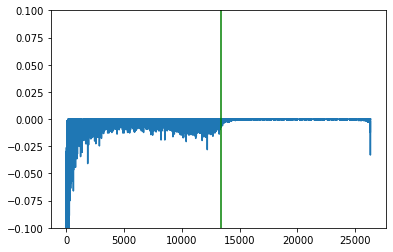

In [29]:
plt.plot(np.diff(stackups['K4_mean'][jjj]))
# print(np.diff(stackups['K4_mean'][jjj])[5000:17000].argmin())
ax = plt.gca()
ax.set_ylim(-0.1,0.1)
ax.axvline(12312+1100,color="green")
number_of_active_TSS = 13412

sorting 13412 elements of G4_mean into 1 groups ...


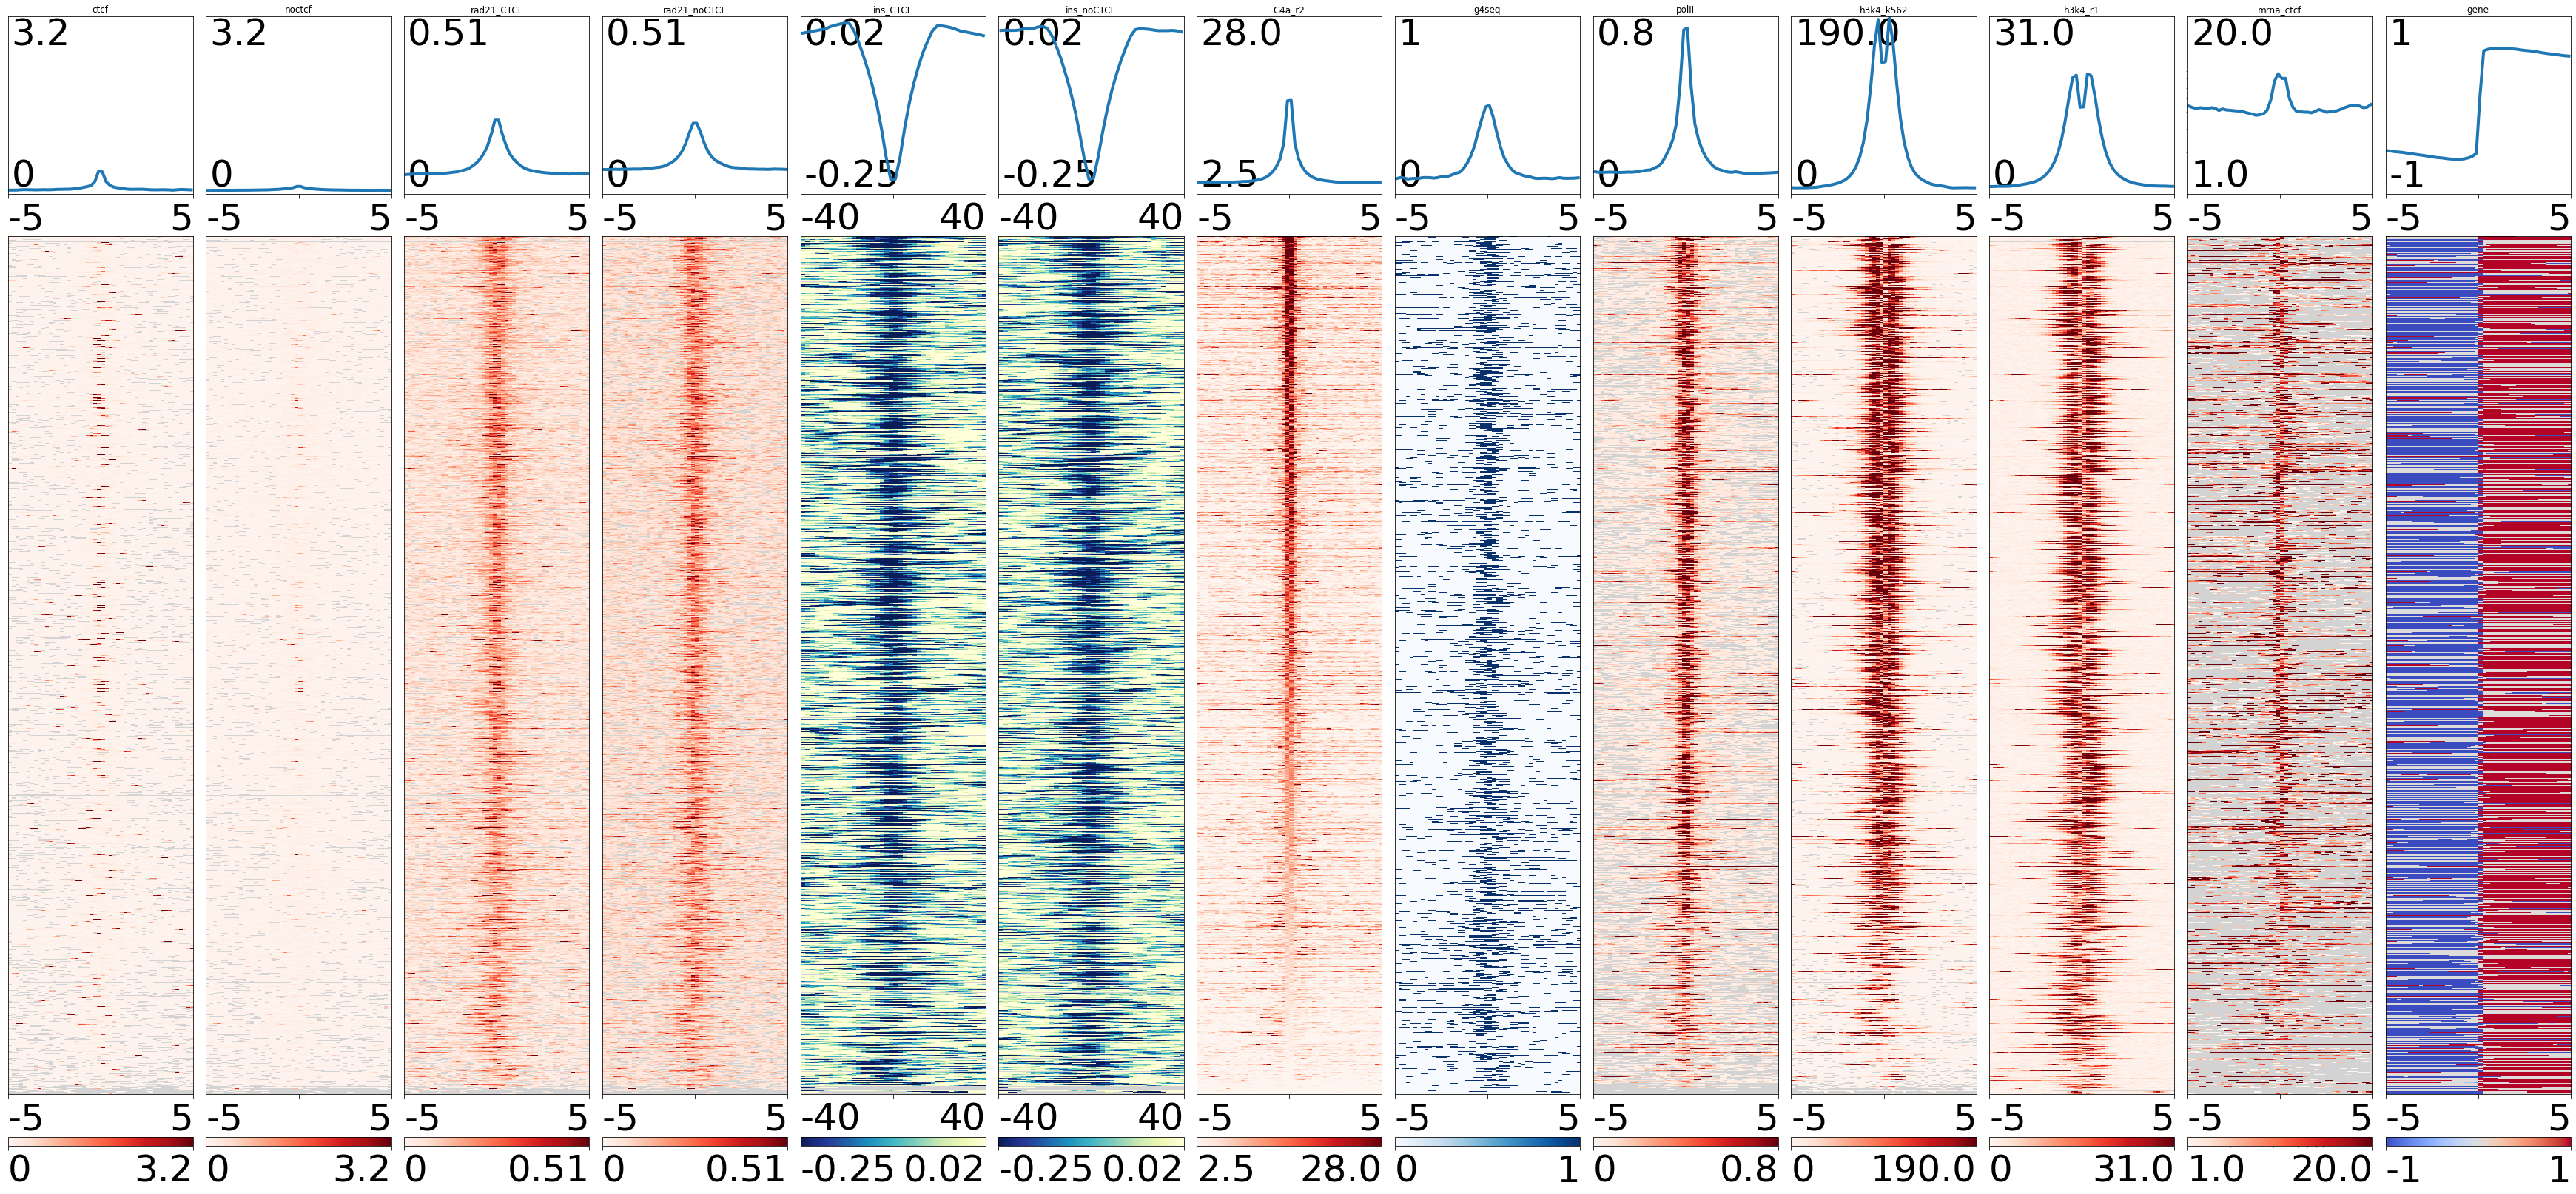

In [31]:
hmss = OrderedDict()
for feature_key in stackup_dict:
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    #
    # let's take ative TSS (according to H3K4) only ...
    iii = jjj[:number_of_active_TSS]
    _l, _w = _stackups['G4a_r2'].shape
    _cent = int(_w/2)
    tmp_dict = {}
    tmp_dict['G4_mean'] = np.nanmean(_stackups['G4a_r2'][iii,_cent-1:_cent+1],axis=1)

    ks = [('G4_mean', "sort", 1, False)]
    _, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)
    #
    hmss[feature_key] = [ _stackups[_k][iii[iii_reord]] for _k in supfig2A_samples ]

_limss = [ limss[_k] for _k in supfig2A_samples ]
_cmps = [ cmps[_k] for _k in supfig2A_samples ]
_binsizes = [ binsizes[_k] for _k in supfig2A_samples ]
_norms = [ norms[_k] for _k in supfig2A_samples ]

extra_order = None
hmss_order = [0,1,2,3,4,5,6,9,8,10,11,12,7]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

plt.savefig("ActiveTSS_HAP1-G4sorted.pdf")

### Creating a list of active TSSs - regardless of CTCF (preserve strand info !)

In [35]:
# save list of Acxtive TSSs :
feature_key = "rad_ctcf_union"
jjj = reordered_jdxs[feature_key]
ddf = dfs[feature_key].loc[jjj[:number_of_active_TSS]].reset_index(drop=True)
fname = f"ActiveTSS-{number_of_active_TSS}-1bp.bed"
ddf.to_csv(fname,index=False,header=None,sep="\t")
print(f"Active TSS are saved to {fname} ...")

Active TSS are saved to ActiveTSS-13412-1bp-XXX.bed ...


### Creating a list of active TSSs without CTCF around it ...

In [45]:
from copy import copy

In [46]:
ctcf_df = bioframe.read_table(
    "NT-CTCF-narrowPeaks-sort-merge", # just our NT CTCF ChipSeq peaks ...
    names=["chrom","start","end"]
)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ ctcf_df["chrom"].isin(autosomal_chroms) ]
ctcf_df = ctcf_df.reset_index(drop=True)

In [47]:
# using existing list of active TSSs - we expand them by 2kb on each side ... -> ddf_exp
ddf = ddf.sort_values(["chrom","start"])
_ddf = copy(ddf.reset_index(drop=True))
ddf_exp = bioframe.expand(_ddf,pad=2_000)

In [53]:
# then overlap expanded TSS with CTCF -peaks, to find TSS without CTCF nearby ...
ddf_exp_ctcf = bioframe.overlap(ddf_exp,ctcf_df,how="left",suffixes=('','_')) # keep all TSS
 # peek those, without CTCF 
_mask_TSS_without_CTCF = pd.isnull( ddf_exp_ctcf["chrom_"] )
ddf_exp_noctcf = ddf_exp_ctcf[_mask_TSS_without_CTCF][["chrom","start","end","strand"]]
ddf_exp_noctcf = ddf_exp_noctcf.astype({"start":int,"end":int})
# there shouldn't be any duplicates, but just in case ...
ddf_exp_noctcf = ddf_exp_noctcf.drop_duplicates().reset_index(drop=True)
print(len(ddf_exp_noctcf))

# now let's undo "expand" in a an easiest way - expand with a negative pad = -2000 ...
ddf_exp_noctcf = bioframe.expand(ddf_exp_noctcf, pad=-2_000)
# make footprints are unique ! - all has to be 1 bp!
(ddf_exp_noctcf["end"]-ddf_exp_noctcf["start"]).value_counts()
# save it ...
fname = f"ActiveTSS-NO-CTCF-{len(ddf_exp_noctcf)}-1bp.bed"
ddf_exp_noctcf.to_csv(fname, index=False, header=None, sep="\t")
print(f"saving Active TSS without CTCF nearby to {fname}")

8849
saving Active TSS without CTCF nearby to ActiveTSS-NO-CTCF-8849-1bp.bed


In [32]:
!scp ActiveTSS_HAP1-G4sorted.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

ActiveTSS_HAP1-G4sorted.pdf                   100% 1556KB 421.6KB/s   00:03    
